# Classification: Star Wars Lego Images

To classify images of star wars figure legos into 5 categories using a convolutional neural network.
<br><br>
References for this tutorial: 
- https://www.youtube.com/watch?v=Li5c49YV9wA
- https://github.com/python-engineer/tensorflow-course/blob/master/08_09_Star_Wars_Project.ipynb

Dataset:
- https://www.kaggle.com/ihelon/lego-minifigures-classification

# Install and Import Modules

Enable GPU:
- Method 1: Edit tab --> Notebook settings --> GPU --> Save.
- Method 2: Runtime tab --> Change runtime type --> GPU --> Save.

Check if GPU is present:

In [1]:
!pip install numpy pandas matplotlib seaborn tensorflow

In [2]:
import os
import math
import random
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
!nvidia-smi

Sun Jul 11 12:09:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    33W /  70W |    222MiB / 15109MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load Dataset and Preprocess Data

- Download the dataset from Kaggle and retain only the 5 folders of star-wars.
- Upload the data folder to your Google Drive.
- Mount your Google Drive to be accessed by your Colab notebook.
- Alternative: Upload directly to Colab for one-time access.

In [5]:
!pwd

/content


Rearrage folders into train, val and test:

In [6]:
BASE_DIR = '/content/drive/MyDrive/Datasets/star-wars/'
names = ["YODA", "LUKE SKYWALKER", "R2-D2", "MACE WINDU", "GENERAL GRIEVOUS"]
train_proportion = 0.6
val_proportion = 0.25
total_train = 0
total_val = 0
total_test = 0

# create new folders
if not os.path.isdir(f'{BASE_DIR}train/'):
    for name in names:
        os.makedirs(f'{BASE_DIR}train/{name}')
        os.makedirs(f'{BASE_DIR}val/{name}')
        os.makedirs(f'{BASE_DIR}test/{name}')

# arrange number of images in each folder
orig_folders = ["0001/", "0002/", "0003/", "0004/", "0005/"]
for folder_idx, folder in enumerate(orig_folders):
    files = os.listdir(BASE_DIR + folder)

    folder_name = names[folder_idx]
    number_of_images = len([name for name in files])

    n_train = int((number_of_images * train_proportion) + 0.5)
    n_valid = int((number_of_images * val_proportion) + 0.5)
    n_test = number_of_images - n_train - n_valid

    total_train += n_train
    total_val += n_valid
    total_test += n_test

    print(f'Folder {folder_name} has {number_of_images} images in total:\n train - {n_train}, val - {n_valid}, test - {n_test}\n')

    # copy images from original folders to the new ones
    for idx, file in enumerate(files):
        file_name = BASE_DIR + folder + file
        if idx < n_train:
            shutil.copy(file_name, f'{BASE_DIR}train/{folder_name}')
        elif idx < n_train + n_valid:
            shutil.copy(file_name, f'{BASE_DIR}val/{folder_name}')
        else:
            shutil.copy(file_name, f'{BASE_DIR}test/{folder_name}')

print(f'The train folder has {total_train} images in total.')
print(f'The val folder has {total_val} images in total.')
print(f'The test folder has {total_test} images in total.')

Folder YODA has 12 images in total:
 train - 7, val - 3, test - 2

Folder LUKE SKYWALKER has 12 images in total:
 train - 7, val - 3, test - 2

Folder R2-D2 has 12 images in total:
 train - 7, val - 3, test - 2

Folder MACE WINDU has 13 images in total:
 train - 8, val - 3, test - 2

Folder GENERAL GRIEVOUS has 14 images in total:
 train - 8, val - 4, test - 2

The train folder has 37 images in total.
The val folder has 16 images in total.
The test folder has 10 images in total.


Create image data generator which includes data preprocessing:

In [7]:
# normalization

train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, 
                                                         rotation_range=20,
                                                         horizontal_flip=True,
                                                         width_shift_range=0.2, 
                                                         height_shift_range=0.2,
                                                         shear_range=0.2, 
                                                         zoom_range=0.2)
valid_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [8]:
# class_mode = sparse: to have the labels as an integer instead of one-hot encoding

target_size = (256, 256)
batch_size = 4

train_batches = train_gen.flow_from_directory(
    f'{BASE_DIR}train',
    target_size=target_size,
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=True,
    color_mode="rgb",
    classes=names   
)

val_batches = valid_gen.flow_from_directory(
    f'{BASE_DIR}val',
    target_size=target_size,
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=False,
    color_mode="rgb",
    classes=names
)

test_batches = test_gen.flow_from_directory(
    f'{BASE_DIR}test',
    target_size=target_size,
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=False,
    color_mode="rgb",
    classes=names
)

Found 37 images belonging to 5 classes.
Found 16 images belonging to 5 classes.
Found 10 images belonging to 5 classes.


In [9]:
train_batch = train_batches[0]
print('Train batch:')
print(f'Input shape: {train_batch[0].shape}')
print(f'Target: {train_batch[1]}')

val_batch = val_batches[0]
print('\nVal batch:')
print(f'Input shape: {val_batch[0].shape}')
print(f'Target: {val_batch[1]}')

test_batch = test_batches[0]
print('\nTest batch:')
print(f'Input shape: {test_batch[0].shape}')
print(f'Target: {test_batch[1]}')

Train batch:
Input shape: (4, 256, 256, 3)
Target: [4. 3. 0. 1.]

Val batch:
Input shape: (4, 256, 256, 3)
Target: [0. 0. 0. 1.]

Test batch:
Input shape: (4, 256, 256, 3)
Target: [0. 0. 1. 1.]


Display batch images with labels:

In [10]:
def show(batch, pred_labels=None):
    plt.figure(figsize=(10,10))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(batch[0][i], cmap=plt.cm.binary)
        # The CIFAR labels happen to be arrays, 
        # which is why you need the extra index
        lbl = names[int(batch[1][i])]
        if pred_labels is not None:
            lbl += "/ Pred:" + names[int(pred_labels[i])]
        plt.xlabel(lbl)
    plt.show()

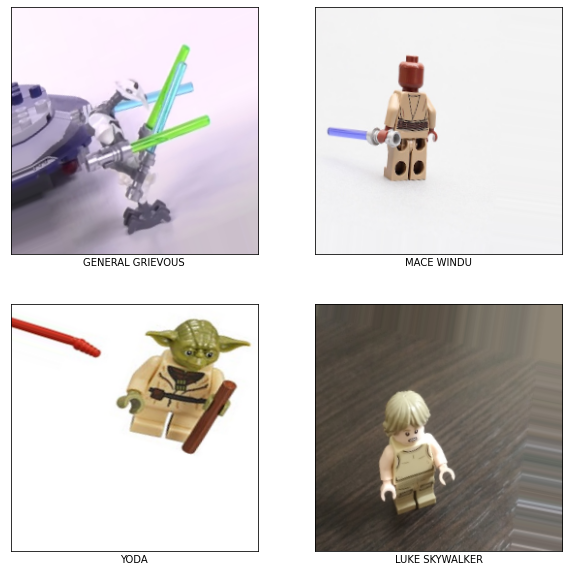

In [11]:
show(train_batch)

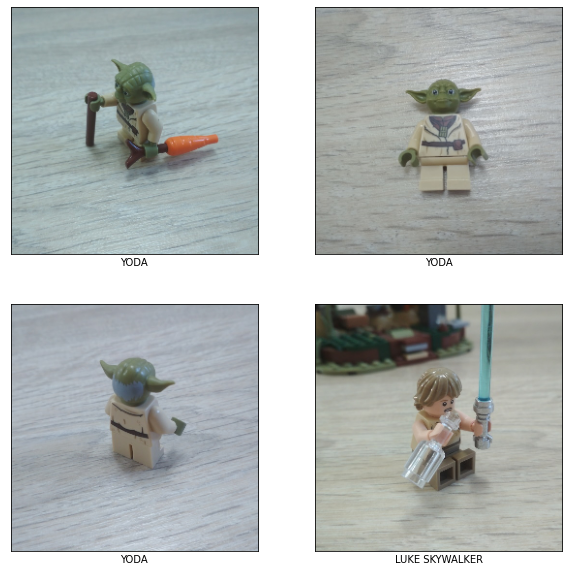

In [12]:
show(val_batch)

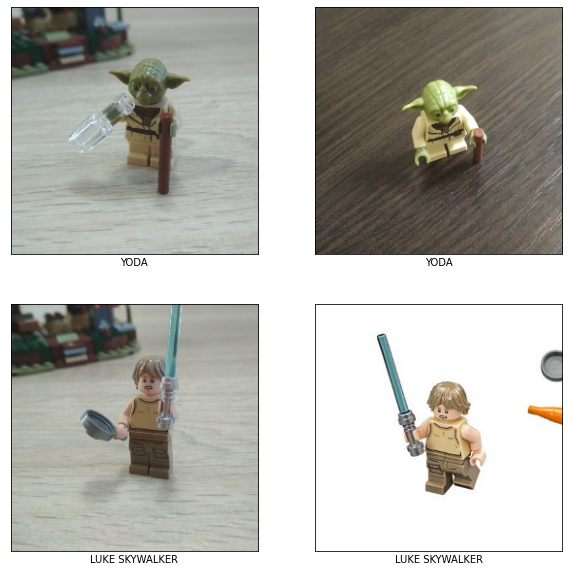

In [13]:
show(test_batch)

# Train and Evaluate Model

Create a CNN model architecture:

In [14]:
model = keras.models.Sequential()
model.add(layers.Conv2D(32, (3,3), 
                        strides=(1,1), 
                        padding="valid", 
                        activation='relu', 
                        input_shape=(256, 256,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 246016)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                15745088  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 3

Compile the model with necessary configs:

In [16]:
# loss and optimizer
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ["accuracy"]

model.compile(optimizer=optim, loss=loss, metrics=metrics)

Train the model with callbacks function:

In [17]:
epochs = 30

# callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=2)

history = model.fit(train_batches, 
                    validation_data=val_batches,
                    callbacks=[early_stopping],
                    epochs=epochs, 
                    verbose=2)


model.save(f"{BASE_DIR}lego_model.h5")

Epoch 1/30
10/10 - 4s - loss: 3.8607 - accuracy: 0.1351 - val_loss: 1.6825 - val_accuracy: 0.1875
Epoch 2/30
10/10 - 1s - loss: 1.6760 - accuracy: 0.1622 - val_loss: 1.6357 - val_accuracy: 0.1875
Epoch 3/30
10/10 - 1s - loss: 1.6070 - accuracy: 0.2162 - val_loss: 1.5375 - val_accuracy: 0.2500
Epoch 4/30
10/10 - 1s - loss: 1.5289 - accuracy: 0.2162 - val_loss: 1.4913 - val_accuracy: 0.1875
Epoch 5/30
10/10 - 1s - loss: 1.5127 - accuracy: 0.2162 - val_loss: 1.3900 - val_accuracy: 0.3750
Epoch 6/30
10/10 - 1s - loss: 1.4470 - accuracy: 0.3514 - val_loss: 1.3002 - val_accuracy: 0.3750
Epoch 7/30
10/10 - 1s - loss: 1.5138 - accuracy: 0.2703 - val_loss: 1.4891 - val_accuracy: 0.3125
Epoch 8/30
10/10 - 1s - loss: 1.3643 - accuracy: 0.5135 - val_loss: 1.5342 - val_accuracy: 0.2500
Epoch 9/30
10/10 - 1s - loss: 1.3964 - accuracy: 0.3784 - val_loss: 1.3372 - val_accuracy: 0.3750
Epoch 10/30
10/10 - 1s - loss: 1.2930 - accuracy: 0.4865 - val_loss: 1.0041 - val_accuracy: 0.7500
Epoch 11/30
10/10 -

Note:
- Early stopping
- Overfitting

Plot the training and validation outcome:

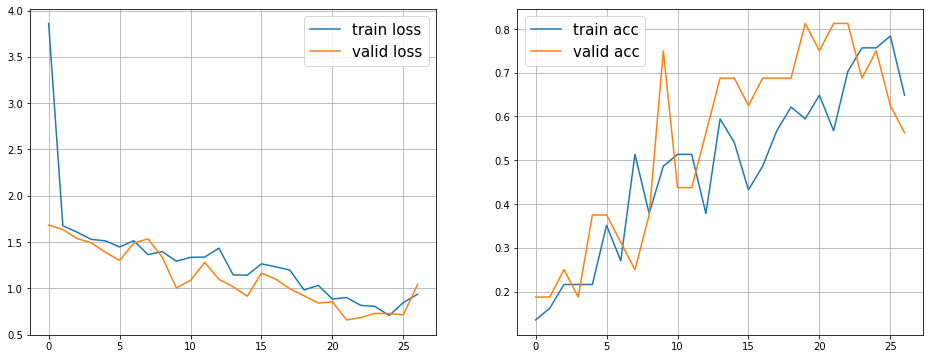

In [18]:
# plot loss and acc
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.grid()
plt.legend(fontsize=15)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='valid acc')
plt.grid()
plt.legend(fontsize=15);

Evaluate model on test data:

In [19]:
model.evaluate(test_batches, verbose=2)

3/3 - 0s - loss: 1.1952 - accuracy: 0.6000


[1.1951550245285034, 0.6000000238418579]

In [20]:
# make some predictions
predictions = model.predict(test_batches)
predictions = tf.nn.softmax(predictions)
labels = np.argmax(predictions, axis=1)

print(test_batches[0][1])
print(labels[0:4])

[0. 0. 1. 1.]
[2 0 2 3]


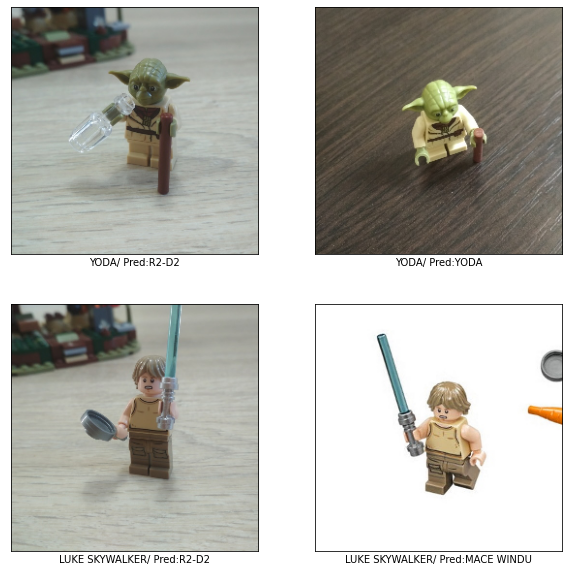

In [21]:
show(test_batches[0], labels[0:4])

# Transfer Learning

In [22]:
vgg_model = tf.keras.applications.vgg16.VGG16()
print(type(vgg_model))
vgg_model.summary()

<class 'tensorflow.python.keras.engine.functional.Functional'>
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
________________________________________________________________

In [23]:
# add all layers to model except the output layer

model = keras.models.Sequential()
for layer in vgg_model.layers[0:-1]:
    model.add(layer)

for layer in model.layers:
    layer.trainable = False

In [24]:
# add a last classification layer for our use case with 5 classes

model.add(layers.Dense(5))

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [26]:
# loss and optimizer

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ["accuracy"]

model.compile(optimizer=optim, loss=loss, metrics=metrics)

In [27]:
# get the preprocessing function of this model

preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [28]:
train_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
valid_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

In [29]:
# class_mode = sparse: to have the labels as an integer instead of one-hot encoding

target_size = (224, 224)
batch_size = 4

train_batches = train_gen.flow_from_directory(
    f'{BASE_DIR}train',
    target_size=target_size,
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=True,
    color_mode="rgb",
    classes=names   
)

val_batches = valid_gen.flow_from_directory(
    f'{BASE_DIR}val',
    target_size=target_size,
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=False,
    color_mode="rgb",
    classes=names
)

test_batches = test_gen.flow_from_directory(
    f'{BASE_DIR}test',
    target_size=target_size,
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=False,
    color_mode="rgb",
    classes=names
)

Found 37 images belonging to 5 classes.
Found 16 images belonging to 5 classes.
Found 10 images belonging to 5 classes.


In [30]:
epochs = 30

# callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=2)

history = model.fit(train_batches, 
                    validation_data=val_batches,
                    callbacks=[early_stopping],
                    epochs=epochs, verbose=2)

model.save(f"{BASE_DIR}lego_model_transfer-learning.h5")

Epoch 1/30
10/10 - 3s - loss: 1.8305 - accuracy: 0.3784 - val_loss: 0.9233 - val_accuracy: 0.6875
Epoch 2/30
10/10 - 1s - loss: 0.5029 - accuracy: 0.7568 - val_loss: 0.4960 - val_accuracy: 0.7500
Epoch 3/30
10/10 - 1s - loss: 0.1064 - accuracy: 0.9459 - val_loss: 0.2641 - val_accuracy: 0.7500
Epoch 4/30
10/10 - 1s - loss: 0.0555 - accuracy: 0.9730 - val_loss: 0.1479 - val_accuracy: 1.0000
Epoch 5/30
10/10 - 1s - loss: 0.0323 - accuracy: 0.9730 - val_loss: 0.3156 - val_accuracy: 0.8125
Epoch 6/30
10/10 - 1s - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.3795 - val_accuracy: 0.8125
Epoch 7/30
10/10 - 1s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.3178 - val_accuracy: 0.8125
Epoch 8/30
10/10 - 1s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.2477 - val_accuracy: 0.8750
Epoch 9/30
10/10 - 1s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.2099 - val_accuracy: 0.8750
Epoch 00009: early stopping


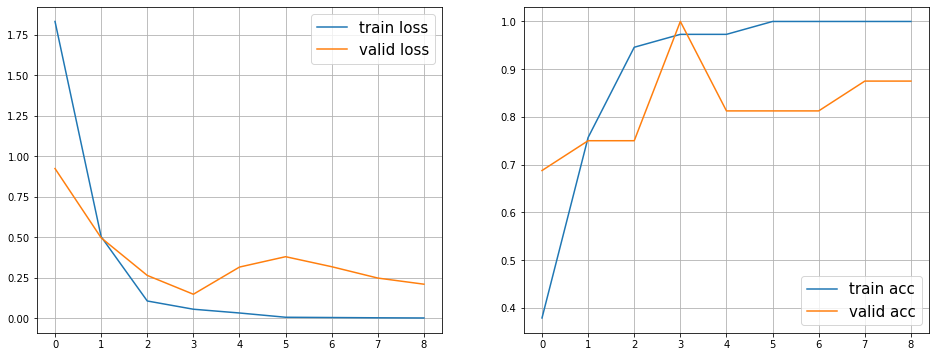

In [31]:
# plot loss and acc
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.grid()
plt.legend(fontsize=15)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='valid acc')
plt.grid()
plt.legend(fontsize=15);

In [32]:
model.evaluate(test_batches, verbose=2)

3/3 - 1s - loss: 0.2886 - accuracy: 0.9000


[0.28858354687690735, 0.8999999761581421]

In [33]:
# make some predictions
predictions = model.predict(test_batches)
predictions = tf.nn.softmax(predictions)
labels = np.argmax(predictions, axis=1)

print(test_batches[0][1])
print(labels[0:4])

[0. 0. 1. 1.]
[0 0 1 3]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


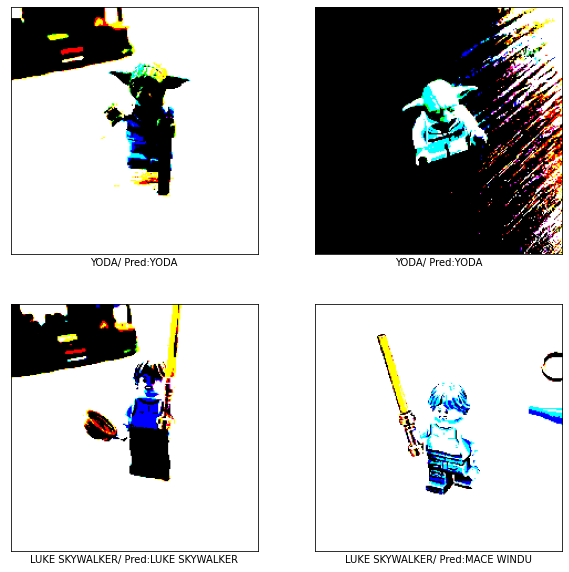

In [34]:
show(test_batches[0], labels[0:4])